In [1]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 1.9 MB/s eta 0:00:00


In [2]:
# Imports
from __future__ import print_function
from time import time
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.svm import SVC
from PIL import Image
import os, numpy
from sklearn import metrics, svm, neighbors
from sklearn.metrics import classification_report
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import cv2
from PIL import Image

# Confirm mtcnn was installed correctly
import mtcnn
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle

from os import listdir
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix, precision_recall_fscore_support
import random
import seaborn as sns
import sys

In [3]:
DIRECTORY = "../input/yale-face-database/"

# 1. Exploratory Data Analysis

The Yale Face Database is made from 165 grayscale images of 15 people. There are 11 images per person with different expressions

(243, 320, 3)


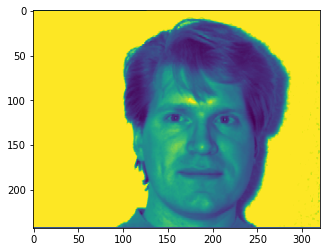

In [4]:
filename = "../input/yale-face-database/subject01.centerlight"
pixels = plt.imread(filename)

# Show RGB shape
rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(rgb_pixels.shape)

# Show example image
plt.imshow(pixels)
plt.show()

To ensure the faces can be reliably fed into a classifier, MTCNN will be used to normalise all the face positions. MTCNN is a face detection algorithm using a CNN, which achieves a high accuracy.

In [5]:
# Create the detector, using default weights
detector = MTCNN()

# Detect faces in the image
results = detector.detect_faces(rgb_pixels)
results

2022-05-27 12:27:02.852546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 12:27:02.945999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 12:27:02.946803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 12:27:02.948087: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

[{'box': [121, 69, 122, 154],
  'confidence': 0.9999041557312012,
  'keypoints': {'left_eye': (160, 122),
   'right_eye': (214, 123),
   'nose': (189, 152),
   'mouth_left': (163, 182),
   'mouth_right': (210, 184)}}]

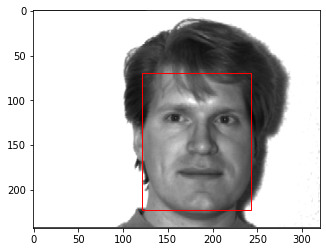

In [6]:
# Draw an image with detected objects
def draw_image_with_boxes(data, result_list):
    
    # Plot the image
    plt.imshow(data)
    
    # Get the context for drawing boxes
    ax = plt.gca()
    
    # Plot each box
    for result in result_list:
        
        # Get coordinates
        x, y, width, height = result['box']
        
        # Create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        
        # Draw the box
        ax.add_patch(rect)
        
    # Show the plot
    plt.show()

# Display faces on the original image
draw_image_with_boxes(rgb_pixels, results)

Again, to ensure the images can be used reliably for classifying, the face pixels will be normalised.

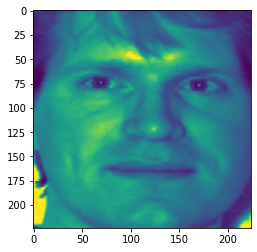

In [7]:
# Extract a single face from a given photograph
def extract_face_from_file(filename, required_size=(224, 224)):
    
    # Load image from file
    image = Image.open(filename)
    
    return extract_face(image, required_size)

def extract_face(image, required_size=(224, 224)):
    # Convert to RGB
    image = image.convert('RGB')
    
    # Convert to array
    pixels = np.asarray(image)
    
    # Detect faces in the image
    results = detector.detect_faces(pixels)
    
    # Extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    
    # Bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    # Extract the face
    face = pixels[y1:y2, x1:x2]
    
    # Resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    gray_face = cv2.cvtColor(face_array, cv2.COLOR_BGR2GRAY)
    
    # Resize image to model size
    face_array[:,:,0] = gray_face
    face_array[:,:,1] = gray_face
    face_array[:,:,2] = gray_face
    
    
    return gray_face


# Create the detector, using default weights
detector = MTCNN()

# Load the photo and extract the face
face_pixels = extract_face_from_file("../input/yale-face-database/subject01.centerlight")

# Show extracted face
plt.imshow(face_pixels)

# 2. Building the Dataset

To create the dataset, all the images will need the faces extracting, as shown below.

100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


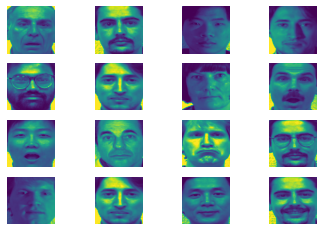

In [8]:
# Returns list of filenames
def list_files(directory, contains):
    return list(f for f in listdir(directory) if contains in f)
i = 1
faces = list()
for filename in tqdm(list_files(DIRECTORY, "subject")[0:16]):
    
    # Path
    path = DIRECTORY + filename
    
    # Get face
    face = extract_face_from_file(path)
    
    # Set up subplot
    plt.subplot(4, 4, i)
    plt.axis('off')
    plt.imshow(face)
    
    # Add face to faces list
    faces.append(face)
    i += 1
plt.show()

# 3. Test and Train

## 3.1 Setup of the Test and Train Data

In [9]:
# List filenames
filenames = pd.DataFrame(list_files(DIRECTORY, "subject"))

# Generate split 
df = filenames[0].str.split(".", expand=True)
df["filename"] = filenames

# Tidy columns
df = df.rename(columns = {0:"subject", 1:"category"})
df['subject'] = df.subject.str.replace('subject' , '')
df.apply(pd.to_numeric, errors='coerce').dropna()
df['subject'] = pd.to_numeric(df["subject"])
df

,subject,category,filename
0,5,surprised,subject05.surprised
1,9,normal,subject09.normal
2,4,rightlight,subject04.rightlight
3,3,leftlight,subject03.leftlight
4,7,glasses,subject07.glasses
...,...,...,...
160,10,noglasses,subject10.noglasses
161,6,centerlight,subject06.centerlight
162,14,centerlight,subject14.centerlight
163,12,normal,subject12.normal


In [10]:
# Print classnames
class_names = df['subject'].unique()
print(class_names)

[ 5  9  4  3  7 11  2 14 12  1  6 15 13  8 10]


## 3.2 Split Test and Train Data

In order to benchmark the models appropriately, the test train split will be 70/30 which is enough for 3 test images, ensuring there is a suitable number of classes to benchmark.

In [11]:
PER_CLASS = 8 # 11 images (3 test & 8 train)
NO_CLASSES = 15
DS_SIZE = df["subject"].count()
TEST_SIZE = 1 - (PER_CLASS * NO_CLASSES / DS_SIZE)

# List files for each group
y = df['subject']
X = df.drop('subject',axis=1)

# Subject
X_train_info, X_test_info, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=45, stratify=y)

# Convert to list
y_train = y_train.tolist()
y_test = y_test.tolist()

# 4. Extract the faces

Extracting the faces, as shown in section 2, but loading into the dataset.

In [12]:
detector = MTCNN()

# Function to load faces into dataset
def load_dataset(dataset):
    faces = list()
    for filename in tqdm(dataset["filename"]):
        path = DIRECTORY + filename
        
        # Get face
        face = extract_face_from_file(path)
        faces.append(face)
    return np.asarray(faces)

In [13]:
# Load dataset
X_test = load_dataset(X_test_info)
X_train = load_dataset(X_train_info)

100%|██████████| 120/120 [00:44<00:00,  2.69it/s]


# 5. Reshape and Normalise

Reshape and Normalise dataset, ready for PCA

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer

# Normalise input vectors, label targets.
in_encoder = Normalizer(norm='l2')

# Reshape X_train
X_train_reshaped = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
print('Reshaped X_train', X_train_reshaped.shape)
X_train_reshaped = in_encoder.transform(X_train_reshaped)

# Reshape X_test
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
print('Reshaped X_test', X_test_reshaped.shape)
X_test_reshaped = in_encoder.transform(X_test_reshaped)

# Normalise Labels
out_encoder = LabelEncoder()
out_encoder.fit(y_train)

Reshaped X_train (120, 50176)
Reshaped X_test (45, 50176)


LabelEncoder()

# 6. Principal Component Analysis (PCA) (Eigen Faces)

## 6.1 Finding optimum number of Principle Component

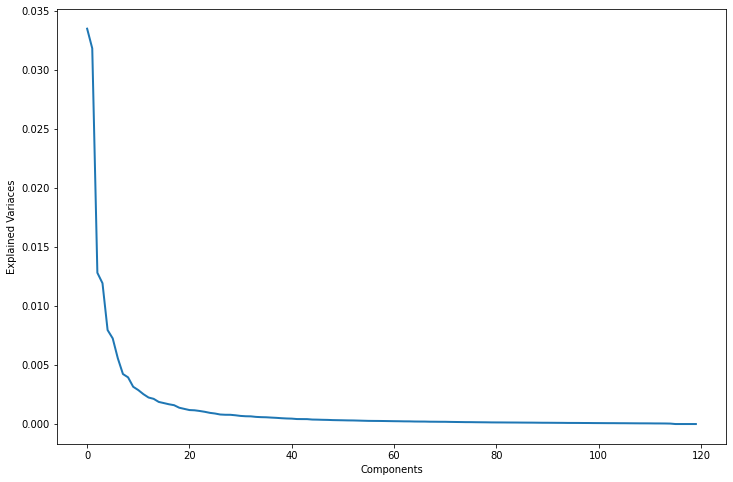

In [15]:
pca=PCA()

# Learns the components and explained variance from the data
pca.fit(X_train_reshaped)

# Set up subplot
plt.figure(1, figsize=(12,8))

# Testing for multiple values
plt.plot(pca.explained_variance_, linewidth=2)

# Set subplot labels
plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()

In the figure above, it can be seen that 60 and more PCA components represent the same data as the line flattens. Now let's make the classification process using 60 PCA components.

In [16]:
n_components=60

In [17]:
# Apply number of components to PCA model
pca=PCA(n_components=n_components, whiten=True)
pca.fit(X_train_reshaped)

PCA(n_components=60, whiten=True)

## 6.2 Show Average Face

Text(0.5, 1.0, 'Average Face')

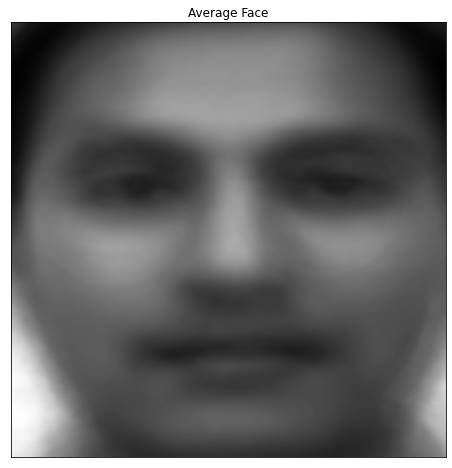

In [18]:
# Set up subplot
fig,ax=plt.subplots(1,1,figsize=(8,8))

# Per-feature mean, estimated from the training set. i.e Average face in dataset
ax.imshow(pca.mean_.reshape((224,224)), cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Face')

## 6.3 Show Eigen Faces

Text(0.5, 0.98, 'All Eigen Faces')

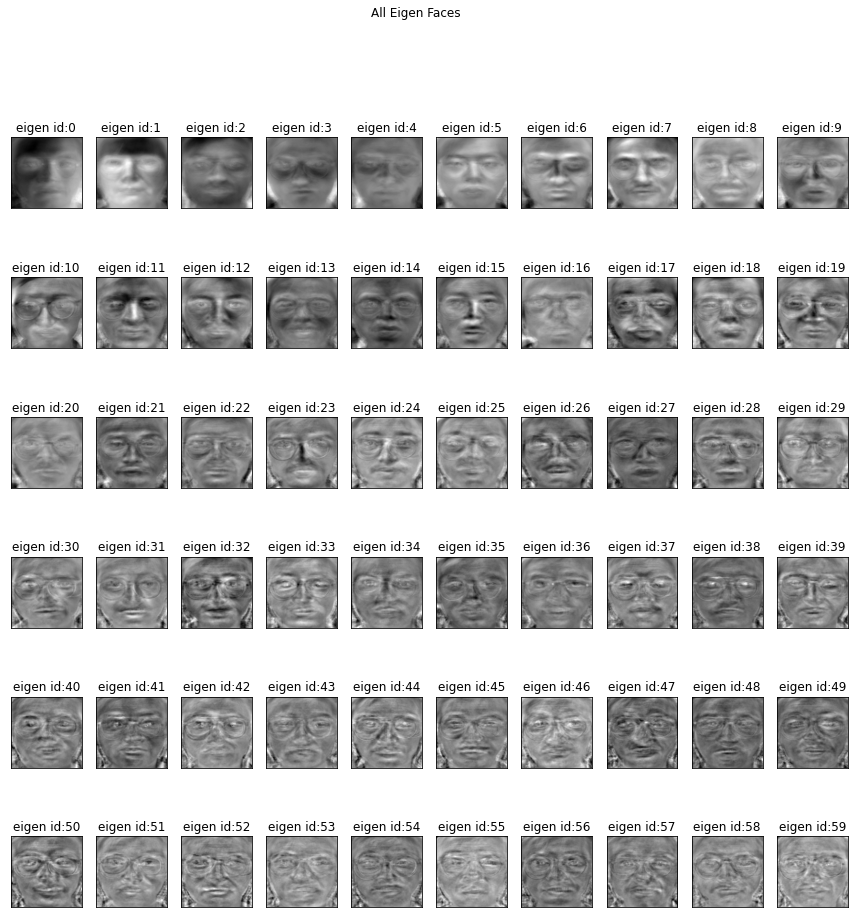

In [19]:
# Get number of eigenfaces
number_of_eigenfaces=len(pca.components_)

# Get eigen faces and shape to appropeite size ready for model predictions
eigen_faces=pca.components_.reshape((number_of_eigenfaces, 224, 224))

# Set up subplot
cols=10
rows=int(number_of_eigenfaces/cols)
fig, axarr=plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

# Collapse to 1D array
axarr=axarr.flatten()

# Iterate through eigen faces
for i in range(number_of_eigenfaces):
    axarr[i].imshow(eigen_faces[i],cmap="gray")
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title("eigen id:{}".format(i))
plt.suptitle("All Eigen Faces".format(10*"=", 10*"="))

## 6.4 Perform Projection 

Perform projection ready for classification prediction models.

In [20]:
# Project each row of data into vector space learned from call to fit in section 6.1
X_train_pca=pca.transform(X_train_reshaped)
X_test_pca=pca.transform(X_test_reshaped)

# 7. Classification Results

## 7.1 PCA(Eigen Faces) + K-Nearest Neighbors (KNN)

In [21]:
# Initialise KNN model
knn = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto')

# Train model using PCA training set
knn.fit(X_train_pca, y_train)

# Predict Output
y_trainPredKNN = knn.predict(X_train_pca)  
y_testPredKNN = knn.predict(X_test_pca)  

# Accuracy Score
acc_knnTest = metrics.accuracy_score(y_test, y_testPredKNN)
print("Test Set accuracy for KNN: {0}".format(acc_knnTest))

#Classification Report
print(classification_report(y_test, y_testPredKNN))

#Confusion Matrix
print("===========Confusion Matrix=============")
print(confusion_matrix(y_test,y_testPredKNN))

Test Set accuracy for KNN: 0.7111111111111111
              precision    recall  f1-score   support

           1       0.75      1.00      0.86         3
           2       0.60      1.00      0.75         3
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00         3
           5       0.75      1.00      0.86         3
           6       0.40      0.67      0.50         3
           7       0.00      0.00      0.00         3
           8       1.00      0.67      0.80         3
           9       1.00      0.67      0.80         3
          10       1.00      0.67      0.80         3
          11       1.00      0.33      0.50         3
          12       1.00      0.33      0.50         3
          13       0.50      0.33      0.40         3
          14       0.50      1.00      0.67         3
          15       0.75      1.00      0.86         3

    accuracy                           0.71        45
   macro avg       0.73      0.71 

## 7.2 PCA(Eigen Faces) + Support Vector Machine (SVM)

In [22]:
# Initialise SVM model
models = SVC(kernel='linear', probability=True)

# Train model using PCA training set
models.fit(X_train_pca, y_train)

# Predict Output
y_trainPredSVM = models.predict(X_train_pca)
y_testPredSVM = models.predict(X_test_pca)

# Accuracy Score
acc_svmTest = metrics.accuracy_score(y_test, y_testPredSVM)
print("Test Set accuracy for SVM: {0}".format(acc_svmTest))

# Classification report
print(classification_report(y_test,y_testPredSVM))

# Confusion matrix
print("===========Confusion Matrix=============")
print(confusion_matrix(y_test,y_testPredSVM))

Test Set accuracy for SVM: 0.9333333333333333
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       0.75      1.00      0.86         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       0.60      1.00      0.75         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      0.67      0.80         3
          11       1.00      1.00      1.00         3
          12       1.00      0.33      0.50         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3

    accuracy                           0.93        45
   macro avg       0.96      0.93 

SVM performs better than KNN which could indicate that the dataset has outliers as SVM can handle outliers better than KNN, therefore producing a better accuracy.

## 7.3 Convolutional Neural Network's

### 7.3.1 CNN Standard

#### 7.3.1.1 Setup Dataset

In [23]:
# Set variables to be used
TRAINING_DATA_DIRECTORY = "data/train"
TESTING_DATA_DIRECTORY = "data/test"
NUM_CLASSES = 15
EPOCHS = 100
BATCH_SIZE = 20
NUMBER_OF_TRAINING_IMAGES = 135
NUMBER_OF_TESTING_IMAGES = 30
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [24]:
import os 

# Function to save datasets ready for CNN
def save_keras_dataset(setname, dataset, labels, per_class):
    data = sorted(list(zip(labels, dataset)), key=lambda x: x[0])
    
    j = 0
    
    # Iterate through, saving images
    for label, gray_img in tqdm(data):
        j = (j% per_class) + 1
        
        # Save train and test data in directory
        directory = f"data/{setname}/class_{label}/"
        if not os.path.exists(directory):
                os.makedirs(directory)
        cv2.imwrite(f"{directory}class_{label}_{j}.png",gray_img)

In [25]:
import shutil
# Delete data if exists
shutil.rmtree(r'data', ignore_errors=True)

# Save datasets
save_keras_dataset("test", X_test, y_test, 3)
save_keras_dataset("train", X_train, y_train, 8)

100%|██████████| 120/120 [00:00<00:00, 1310.17it/s]


#### 7.3.1.2 Configure Data Generators

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Augment images
def data_generator():
    return ImageDataGenerator(
        rescale=1./255,      
    )

In [27]:
# Configure Data Generators
training_generator = data_generator().flow_from_directory(
    TRAINING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

testing_generator = data_generator().flow_from_directory(
    TESTING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical',
)

validation_generator = data_generator().flow_from_directory(
    TESTING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical',
    shuffle=False
)

Found 120 images belonging to 15 classes.
Found 45 images belonging to 15 classes.
Found 45 images belonging to 15 classes.


#### 7.3.1.3 Example Images

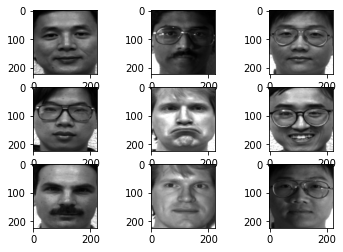

In [28]:
# Show some example images from the dataset
sample_images = testing_generator.next()[0]

f, xyarr = plt.subplots(3,3)
xyarr[0,0].imshow(sample_images[0])
xyarr[0,1].imshow(sample_images[1])
xyarr[0,2].imshow(sample_images[2])
xyarr[1,0].imshow(sample_images[3])
xyarr[1,1].imshow(sample_images[4])
xyarr[1,2].imshow(sample_images[5])
xyarr[2,0].imshow(sample_images[6])
xyarr[2,1].imshow(sample_images[7])
xyarr[2,2].imshow(sample_images[8])
plt.show()

#### 7.3.1.4 Add Layers

In [29]:
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, ZeroPadding2D, MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers, constraints

model = models.Sequential()

# Convolutional and Pooling Layer 1
model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), padding='same'))
model.add(MaxPooling2D((2, 2)))

# Convolutional and Pooling Layer 2
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional and Pooling Layer 3
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten Dataset into 1D array for input into fully connected layer
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(512, activation='relu', kernel_initializer="glorot_uniform", kernel_regularizer=regularizers.l2(l2=0.01)))

# Apply Dropout to Input
model.add(Dropout(0.5))

# Build Output Layer
model.add(Dense(NUM_CLASSES, activation='softmax', kernel_initializer="glorot_uniform"))

In [30]:
# Show layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 53, 53, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 86528)             0

#### 7.3.1.5 Train

In [31]:
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping

# Configure Model for Training
model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(learning_rate=0.00040),
    metrics=["accuracy"]
)

# Train model
history = model.fit(
    training_generator,
    steps_per_epoch=(NUMBER_OF_TRAINING_IMAGES//BATCH_SIZE ),
    epochs=EPOCHS,
    validation_data=testing_generator,
    shuffle=True,
    validation_steps=(NUMBER_OF_TESTING_IMAGES//BATCH_SIZE),
)

Epoch 1/100
6/6 [==============================] - 2s 127ms/step - loss: 13.2435 - accuracy: 0.0750 - val_loss: 9.8166 - val_accuracy: 0.1875
Epoch 2/100
6/6 [==============================] - 0s 56ms/step - loss: 8.6820 - accuracy: 0.1667 - val_loss: 7.4300 - val_accuracy: 0.2812
Epoch 3/100
6/6 [==============================] - 0s 65ms/step - loss: 6.8226 - accuracy: 0.3417 - val_loss: 6.1952 - val_accuracy: 0.6250
Epoch 4/100
6/6 [==============================] - 0s 55ms/step - loss: 5.8132 - accuracy: 0.4333 - val_loss: 5.4219 - val_accuracy: 0.5625
Epoch 5/100
6/6 [==============================] - 0s 58ms/step - loss: 4.9500 - accuracy: 0.5000 - val_loss: 4.5168 - val_accuracy: 0.9062
Epoch 6/100
6/6 [==============================] - 0s 61ms/step - loss: 4.1236 - accuracy: 0.6833 - val_loss: 3.7881 - val_accuracy: 0.8438
Epoch 7/100
6/6 [==============================] - 0s 53ms/step - loss: 3.5316 - accuracy: 0.7667 - val_loss: 3.2676 - val_accuracy: 0.9062
Epoch 8/100
6/6 [=

#### 7.3.1.6 Results

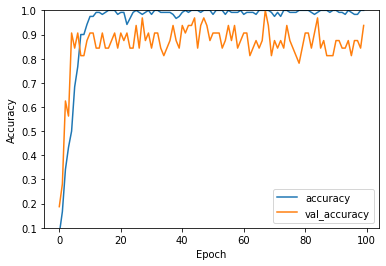

In [32]:
# Accuracy over 100 Epochs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

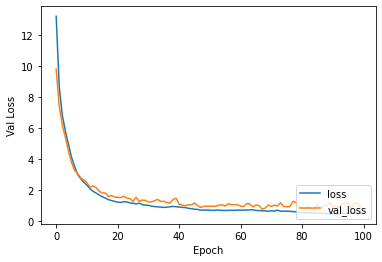

In [33]:
# Loss over 100 Epochs
plot_folder = "plot"
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.legend(loc='lower right')

In [34]:
# Predict Output
Y_pred = model.predict(validation_generator)

# Index that has the maximum probability
y_pred = np.argmax(Y_pred, axis=1)

# Accuracy Score
acc_cnnTest = metrics.accuracy_score(validation_generator.classes, y_pred)
print("Test Set accuracy for CNN: {0}".format(acc_cnnTest))

# Classification report
print(classification_report(validation_generator.classes, y_pred))

# Confusion matrix
print("===========Confusion Matrix=============")
print(confusion_matrix(validation_generator.classes, y_pred))

Test Set accuracy for CNN: 0.8666666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.67      0.80         3
           2       0.75      1.00      0.86         3
           3       1.00      0.67      0.80         3
           4       0.50      1.00      0.67         3
           5       1.00      0.67      0.80         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       0.75      1.00      0.86         3
          11       0.75      1.00      0.86         3
          12       1.00      0.33      0.50         3
          13       1.00      1.00      1.00         3
          14       1.00      0.67      0.80         3

    accuracy                           0.87        45
   macro avg       0.92      0.87 

### 7.3.2 CNN Xception

#### 7.3.2.1 Setup Dataset

In [35]:
# Re-Initialise file path variables
TRAINING_DATA_DIRECTORY = "data/trainXception"
TESTING_DATA_DIRECTORY = "data/testXception"

In [36]:
import shutil
# Delete data if exists
shutil.rmtree(r'data', ignore_errors=True)

# Re-Save datasets under new name
save_keras_dataset("testXception", X_test, y_test, 3)
save_keras_dataset("trainXception", X_train, y_train, 8)

100%|██████████| 120/120 [00:00<00:00, 1304.79it/s]


#### 7.3.2.2 Configure Data Generators

In [37]:
# Re-Configure Data Generators with new file paths
training_generator = data_generator().flow_from_directory(
    TRAINING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

testing_generator = data_generator().flow_from_directory(
    TESTING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical',
)

validation_generator = data_generator().flow_from_directory(
    TESTING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical',
    shuffle=False
)

Found 120 images belonging to 15 classes.
Found 45 images belonging to 15 classes.
Found 45 images belonging to 15 classes.


#### 7.3.2.3 Example Images

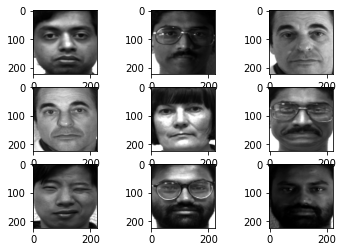

In [38]:
# Show some example images from the dataset
sample_images = testing_generator.next()[0]

f, xyarr = plt.subplots(3,3)
xyarr[0,0].imshow(sample_images[0])
xyarr[0,1].imshow(sample_images[1])
xyarr[0,2].imshow(sample_images[2])
xyarr[1,0].imshow(sample_images[3])
xyarr[1,1].imshow(sample_images[4])
xyarr[1,2].imshow(sample_images[5])
xyarr[2,0].imshow(sample_images[6])
xyarr[2,1].imshow(sample_images[7])
xyarr[2,2].imshow(sample_images[8])
plt.show()

#### 7.3.2.4 Add Layers

In [39]:
from tensorflow.keras.applications.xception import Xception
# Initialise Xception Model
Xception_model = Xception(input_shape=(224,224,3), weights='imagenet',include_top=False, pooling="avg")

model=models.Sequential()
model.add(Xception_model)

# Flatten Dataset into 1D array for input into fully connected layer
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(1024,activation='relu'))

# Apply Dropout to Input
model.add(Dropout(0.5))

# Build Output Layer
model.add(Dense(NUM_CLASSES,activation='softmax'))

83697664/83683744 [==============================] - 2s 0us/step


In [40]:
# Show layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 15)                15375     
Total params: 22,975,031
Trainable params: 22,920,503
Non-trainable params: 54,528
_________________________________________________________________


#### 7.3.2.5 Train

In [41]:
# Configure Model for Training
model.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=0.00040),
    metrics=["accuracy"]
)

# Train Model
history = model.fit(
    training_generator,
    steps_per_epoch=(NUMBER_OF_TRAINING_IMAGES//BATCH_SIZE ),
    epochs=EPOCHS,
    validation_data=testing_generator,
    validation_steps=(NUMBER_OF_TESTING_IMAGES//BATCH_SIZE),
)

Epoch 1/100
6/6 [==============================] - 7s 492ms/step - loss: 2.5038 - accuracy: 0.2000 - val_loss: 2.5675 - val_accuracy: 0.3125
Epoch 2/100
6/6 [==============================] - 2s 288ms/step - loss: 1.5075 - accuracy: 0.7583 - val_loss: 2.2098 - val_accuracy: 0.3750
Epoch 3/100
6/6 [==============================] - 2s 289ms/step - loss: 0.6354 - accuracy: 0.9000 - val_loss: 1.9865 - val_accuracy: 0.3125
Epoch 4/100
6/6 [==============================] - 2s 286ms/step - loss: 0.1202 - accuracy: 0.9917 - val_loss: 1.6438 - val_accuracy: 0.5000
Epoch 5/100
6/6 [==============================] - 2s 291ms/step - loss: 0.0237 - accuracy: 1.0000 - val_loss: 1.2097 - val_accuracy: 0.6562
Epoch 6/100
6/6 [==============================] - 2s 285ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.9147 - val_accuracy: 0.6875
Epoch 7/100
6/6 [==============================] - 2s 286ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.7886 - val_accuracy: 0.7188
Epoch 8/100
6

#### 7.3.2.6 Results

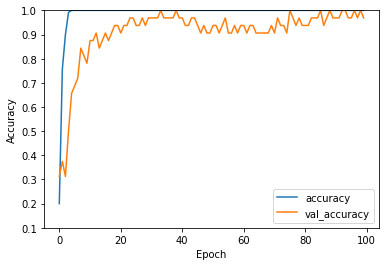

In [42]:
# Accuracy over 100 Epochs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

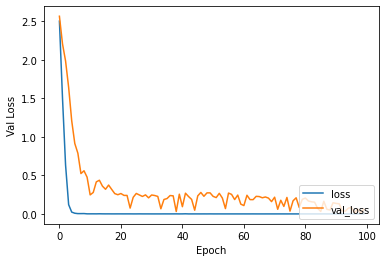

In [43]:
# Loss over 100 Epochs
plot_folder = "plot"
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.legend(loc='lower right')

In [44]:
# Predict Output
Y_pred = model.predict(validation_generator)

# Index that has the maximum probability
y_pred = np.argmax(Y_pred, axis=1)

# Accuracy Score
acc_cnnXceptionTest = metrics.accuracy_score(validation_generator.classes, y_pred)
print("Test Set accuracy for CNN Xception: {0}".format(acc_cnnXceptionTest))

# Classification report
print(classification_report(validation_generator.classes, y_pred))

# Confusion matrix
print("===========Confusion Matrix=============")
print(confusion_matrix(validation_generator.classes, y_pred))

Test Set accuracy for CNN Xception: 0.9777777777777777
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.75      1.00      0.86         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      0.67      0.80         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3

    accuracy                           0.98        45
   macro avg       0.98  

CNN Xception model performed better than the standard CNN model as it has a much deeper architecture that involves Depthwise Separable Convolutions